# Machine learning for maternal health: predicting delivery location in a community health worker program in Zanzibar
## Supporting code
Alma Fredriksson, June 2020, 
Department of Biostatistics, 
Harvard T.H. Chan School of Public Health

### Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.utils import resample
from sklearn.exceptions import ConvergenceWarning
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE

from warnings import filterwarnings

### Enabling functions

In [2]:
#Input: Predictor set
#Output: Predictor set with a baseline dummy variable dropped for each categorical variable
def drop_bline_factor(predictor_set): 
    log_reg_predictors = predictor_set.drop(columns=['district_c_1',
                                            'delivery_facility_name_c_Abdallah Mzee District Hospital',
                                            'delivery_facility_type_c_1',
                                            'roof_pov_1.0',
                                            'floor_pov_1.0',
                                            'drinking_water_pov_1.0',
                                            'chv_experience_6_month_cat_12',
                                            'parity_cat_0'])
    return log_reg_predictors

In [3]:
#Input: true labels, logistic predicted labels, LASSO predicted labels, random forest predicted labels
#Output: Formatted table of results
def summary_table(y_test,log_pred,reg_log_pred,rf_pred):
    
    #count occurrences of each class
    n_home = y_test[y_test==0].value_counts()[0]
    n_facility = y_test[y_test==1].value_counts()[1]
    
    #turn probabilites into classifications
    log_pred_class = np.round(log_pred)
    reg_log_pred_class = np.round(reg_log_pred)
    rf_pred_class = np.round(rf_pred)

    #format output table
    model_df = [
        { 
            'classifier': 'Logistic Regression',
            'test accuracy  (home deliveries)': confusion_matrix(y_test, log_pred_class)[0,0]/n_home,
            'test accuracy (facility deliveries)': confusion_matrix(y_test, log_pred_class)[1,1]/n_facility,
            'test accuracy   (overall)': accuracy_score(y_test,log_pred_class),
            'AUC': roc_auc_score(y_test.astype("int"), log_pred),
        },
        { 
            'classifier': 'Regularized Logistic Regression',
            'test accuracy  (home deliveries)': confusion_matrix(y_test, reg_log_pred_class)[0,0]/n_home,
            'test accuracy (facility deliveries)': confusion_matrix(y_test, reg_log_pred_class)[1,1]/n_facility,
            'test accuracy   (overall)': accuracy_score(y_test,reg_log_pred_class),
            'AUC': roc_auc_score(y_test.astype("int"), reg_log_pred),
        },
        { 
            'classifier': 'Random Forest',
            'test accuracy  (home deliveries)': confusion_matrix(y_test, rf_pred_class)[0,0]/n_home,
            'test accuracy (facility deliveries)': confusion_matrix(y_test, rf_pred_class)[1,1]/n_facility,
            'test accuracy   (overall)': accuracy_score(y_test,rf_pred_class),
            'AUC': roc_auc_score(y_test.astype("int"), rf_pred),
        },
    ]

    results_df = pd.DataFrame(model_df)
    return results_df.round(3)

## Set-up

We import a clean subset of the Safer Deliveries data, which contains all observations until the end of the program in 2020 that satisfy the following: 
* have delivery data available 
* was not a miscarriage. 

The script used to generate this file is available as *safer_deliveries.R*.

In [4]:
#version check
print(sklearn.__version__)
print(tf.__version__)

0.23.1
2.4.1


In [5]:
#import data
sd = pd.read_csv('../data/sd_preprocessed.csv')

We select the relevant variables, who are available at the first CHV visit **and** expected to be predictive of facility delivery. 

In [6]:
#create subset of relevant predictors that are available after the first CHV visit
df_baseline = sd[["district_c","shehia_rate","partner_permission_c",
                  "delivery_facility_taxi_c","gestationage_enrollment_v",
                  "abortions_ob","parity_cat","stillbirths_ob","age_ob",
                  "cardiac_disease_ob","high_bp_ob","macrosomia_ob",
                  "twins_ob","previous_eclampsia_ob",
                  "previous_perineal_tear_ob","previous_placenta_previa_ob",
                  "previous_pph_ob","previous_prolonged_labor_ob",
                  "previous_retained_placenta_ob","previous_vacuum_ob",
                  "prior_c_section_ob","prev_deliv_location_clean",
                  "facility_delivery_dl", "all_children_living_pov","electricity_pov",
                  "drinking_water_pov", "education_pov","roof_pov", "floor_pov",
                  "hivstatusknown_c","delivery_facility_name_c","delivery_facility_type_c",
                  "total_anc_before_enrollment","referred_firstpregvisit","sav_acq_personal_savings_c",
                  "sav_acq_husband_relatives_c","sav_acq_vsla_loan_c","sav_acq_private_loan_c",
                  "sav_acq_other_c",'anc1_before_enrollment','reg_rch_obtained_v',
                  'reg_hivpositive_v','amount_saved_v',"anc1_danger_sign_mother_convulsions_p",
                  "anc1_danger_sign_mother_abpain_p","anc1_danger_sign_mother_bleeding_p",
                  "anc1_danger_sign_mother_headache_p","anc1_danger_sign_mother_breathing_p",
                  "anc1_payment_fee_p","reg_referred_emergency_r",
                  "pregnantbleeding_r", "pregnantdizziness_r","pregnantfatigue_r",
                  "pregnantgastricpain_r","pregnantheadache_r","pregnantlaborpain_r",             
                  "pregnantmalaria_r","pregnantnofetalmove_r","pregnantpalepallor_r",
                  "pregnantrespiratory_r","pregnantswelling_r","pregnanttinnitus_r",              
                  "pregnantunconscious_r","pregnantvaginaldischarge_r","pregnantvaginalleak_r",
                  "anc1_bad_experience",'chv_rate', 'shehia_chv_inter','chv_experience_6_month_cat'
                 ]]
               
#add interaction between previous delivery location and parity
df_baseline.loc[:,'interaction'] = 10*df_baseline['parity_cat']+df_baseline['prev_deliv_location_clean']

#convert to string to allow for dummy creation
df_baseline.loc[:,'interaction'] = [str(x) for x in df_baseline['interaction']]

/Users/alma/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/alma/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Finally, we check the balance of the outcome class, *facility_delivery_dl*, in our training set and find that there are significantly more facility deliveries than home deliveries (reflecting the true distribution in Zanzibar). 

In [43]:
#check outcome balance in training set
df_baseline.facility_delivery_dl.value_counts()

1    29679
0     9108
Name: facility_delivery_dl, dtype: int64

## Data Preprocessing 

The observations are randomly split into a training set, consisting of 80% of the observations, and a test set, consisting of the remaining 20%. The proportion of home vs. facility deliveries is kept constant across the two sets. Dummy encoding is created for categorical variables. 

In [44]:
#create baseline training and test set
X_train_full, X_test_full, y_train, y_test = train_test_split(df_baseline.loc[:, df_baseline.columns != 'facility_delivery_dl'], 
                                                         df_baseline.facility_delivery_dl, test_size=0.2, 
                                                         random_state = 255, 
                                                         stratify = df_baseline.facility_delivery_dl)

#create dummy encoding for categorical variables
X_train_full_dummy = pd.get_dummies(X_train_full,columns=['district_c','delivery_facility_name_c',
                                               'delivery_facility_type_c','roof_pov','floor_pov','drinking_water_pov',
                                                'chv_experience_6_month_cat', 'parity_cat','interaction'])

X_test_full_dummy = pd.get_dummies(X_test_full,columns=['district_c','delivery_facility_name_c',
                                             'delivery_facility_type_c','roof_pov','floor_pov','drinking_water_pov',
                                                'chv_experience_6_month_cat', 'parity_cat','interaction'])    

#only include previous delivery location as part of interaction term and 
#remove invalid interaction terms (women with parity 0 have no previous delivery location)
X_train_clean = X_train_full_dummy.drop(columns=['prev_deliv_location_clean','interaction_4.0','interaction_nan'])
X_test_clean = X_test_full_dummy.drop(columns=['prev_deliv_location_clean','interaction_4.0','interaction_nan'])

For the categorical variables, e.g. shehia, the test set may contain not contain the same set of values as the training set (there could be new CHVs or perhaps not all shehias are represented). We adjust for this below.

In [45]:
#get missing columns in the training test
missing_cols = set(X_train_clean.columns) - set(X_test_clean.columns)

#add a missing column in test set with default value equal to 0
for col in missing_cols:
    X_test_clean[col] = 0

#ensure the order of column in the test set is the same as in training set
X_test_clean = X_test_clean[X_train_clean.columns]

About 10,000 of the women in the dataset are missing information about poverty indicators (education, access to electricity, roof material etc.). To avoid having to discard these observations completely we choose to impute values for these variables based on the information that **is** available. One approach to this is KNN imputation which finds the K most similar observations and assigns the missing variables according to an average (continuous variables) or a majority vote (discrete variables). Similarity is measured based on Euclidean distance and normalization is necessary to ensure that the scale is the same across all variables.

In [46]:
#set up scaler and imputer
scaler = MinMaxScaler()
imputer = KNNImputer(n_neighbors=5)

#normalize data to interval [0,1] to ensure that variables are comparable
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_clean),columns = X_train_clean.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_clean),columns = X_test_clean.columns)

#perform imputation
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_scaled),columns = X_train_scaled.columns,index=y_train.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_scaled),columns = X_test_scaled.columns, index=y_test.index)

## Addressing outcome imbalance

One approach to addressing the imbalance of home vs. facility deliveries is to undersample from the facility deliveries in the training set i.e. to randomly select a subset of facility deliveries of the same size as the number of home deliveries. As a result, we will not make full use of the information available, but we will avoid the issue of poorer classification of home deliveries directly due to the imbalance of delivery facility types.

In [47]:
# combine predictors and outcome
df_imputed = X_train_imputed.copy()
df_imputed['facility_delivery_dl'] = y_train

# undersample facility deliveries
facilities_downsampled = resample(df_imputed[y_train==1],
                                replace = False, # sample without replacement
                                n_samples = len(df_imputed[y_train==0]), # match number of home deliveries
                                random_state = 255)

# create undersampled training set and split outcome and predictors
train_full_under = pd.concat([facilities_downsampled, df_imputed[y_train==0]])
X_train_under = train_full_under.drop(columns=['facility_delivery_dl'])
y_train_under = train_full_under.facility_delivery_dl

# checking counts
y_train_under.value_counts()

1    7286
0    7286
Name: facility_delivery_dl, dtype: int64

Another approach to imbalance across the outcome classes is to oversample from the minority class (home deliveries), which means that some observations will occur multiple times in the training set. Unlike the undersampling method, this approach makes full use of all the data in the sample, but at the risk of resulting in overfitting to the training set (since many of the home delivery records will occur multiple times). In this case, we will resample from the home deliveries until the two classes have the same size (~16,400 observations each).

In [48]:
# oversample facility deliveries
home_oversampled = resample(df_imputed[y_train==0],
                                replace = True, # sample with replacement
                                n_samples = len(df_imputed[y_train==1]), # match number of facility deliveries
                                random_state = 255)

# create oversampled training set
train_full_over = pd.concat([home_oversampled, df_imputed[y_train==1]])
X_train_over = train_full_over.drop(columns=['facility_delivery_dl'])
y_train_over = train_full_over.facility_delivery_dl

# checking counts
train_full_over.facility_delivery_dl.value_counts()

1    23743
0    23743
Name: facility_delivery_dl, dtype: int64

An additional way of addressing the imbalance issue is to create synthetic records corresponding to home deliveries. This can be done using the Synthethic Minority Oversampling Technique (SMOTE), which generates records that are 'similar' to those of women who actually delivery at home. More specifically, the algorithm randomly selects a true home delivery, as well as one of its five nearest neighbors (with proximity being measured as absolute distance in p-dimensional space). A random point is then selected on the line connecting these observations in the feature space and this is our synthethic record. 

To avoid relying too heavily on synthetic records without compromising on the outcome balance, we will undersample from the facility deliveries and create about 5,000 synthethic home deliveries, resulting in a total of 10,000 observations in each class. 

In [49]:
#undersample facility deliveries
facilities_undersampled = resample(df_imputed[y_train==1],
                                replace = False, # sample without replacement
                                n_samples = 15000, # set number of each class
                                random_state = 255)

# create undersampled training set
train_full_temp = pd.concat([facilities_undersampled, df_imputed[y_train==0]])

#separate predictors and outcome
X_train_temp = train_full_temp.drop(columns=['facility_delivery_dl'])
y_train_temp = train_full_temp.facility_delivery_dl

#add synthetic records
sm = SMOTE(sampling_strategy='minority',random_state=255)
X_train_smote, y_train_smote = sm.fit_sample(X_train_temp, y_train_temp)

# checking counts
y_train_smote.value_counts()

1    15000
0    15000
Name: facility_delivery_dl, dtype: int64

## Logistic Regression

For logistic regression, we change the encoding of the categorical variables from dummy to one-hot encoding to ensure that the columns of the design matrix are linearly independent. We drop one of the categories for each factor. 

In [50]:
#create logistic reg version of training and test sets
X_train_under_log = drop_bline_factor(X_train_under)
X_train_over_log  = drop_bline_factor(X_train_over)
X_train_smote_log = drop_bline_factor(X_train_smote)
X_test_log = drop_bline_factor(X_test_imputed)

In [51]:
# perform logistic regression
log_under = LogisticRegression(C=100000,solver='lbfgs',max_iter=2000).fit(X_train_under_log,y_train_under)
log_over = LogisticRegression(C=100000,solver='lbfgs',max_iter=1000).fit(X_train_over_log,y_train_over)
log_smote = LogisticRegression(C=100000,solver='saga',max_iter=2000).fit(X_train_smote_log,y_train_smote)

In [52]:
#make predictions
log_under_pred = log_under.predict_proba(X_test_log)[:,1]
log_over_pred = log_over.predict_proba(X_test_log)[:,1]
log_smote_pred = log_smote.predict_proba(X_test_log)[:,1]

## Regularized Logistic Regression

We proceed with a logistic regression model that uses LASSO regularization as a means of feature selection. This technique includes the sum of the magnitude of the beta coefficients in the loss function. As the loss function is minimized the coefficients for some of the "less predictive" covariates will shrink to 0. 

In [56]:
#logistic regression with LASSO and 5-fold cross validation
C_vals = [1e-2,3e-2,5e-2,7e-2,9e-2,0.01]
reg_log_under = LogisticRegressionCV(Cs=C_vals,penalty = 'l1',cv=5,solver='liblinear').fit(X_train_under,y_train_under)
reg_log_over = LogisticRegressionCV(Cs=C_vals,penalty = 'l1',cv=5,solver='liblinear').fit(X_train_over,y_train_over)
reg_log_smote = LogisticRegressionCV(Cs=C_vals,penalty = 'l1',cv=5,solver='saga').fit(X_train_smote,y_train_smote)

In [57]:
#make predictions
reg_log_under_pred = reg_log_under.predict_proba(X_test_imputed)[:,1]
reg_log_over_pred = reg_log_over.predict_proba(X_test_imputed)[:,1]
reg_log_smote_pred = reg_log_smote.predict_proba(X_test_imputed)[:,1]

## Random Forest

An extension of the simple decision tree is the random forest algorithm, which uses an average prediction based on a larger set of decision trees (= a forest). Each tree is based on a bootstrapped sample from the training set and each split in the tree is constrained to a random subset of features (which reduces the correlation between different trees). 

NOTE: Tree-based models consider variables sequentially, which makes them suitable for considering interactions without specifying them. Interactions that are useful for prediction will generally be picked up with a large enough forest.

In addition to the model parameters, which are tuned during model fitting, there are also several hyperparameters which we tune using a cross validated randomized search. We define possible ranges for each of n_estimators (the number of trees), max_features (the maximum number of features to consider at each split)and max_depth (the maximum tree depth), then test a random subset of the resulting parameter combinations. 

In [58]:
#number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num =5)]
#number of features to consider at every split
max_features = [int(x) for x in np.linspace(start = 15, stop = 40, num = 5)]
#maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 10, num = 5)]

#create random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}
print(random_grid)

{'n_estimators': [100, 325, 550, 775, 1000], 'max_features': [15, 21, 27, 33, 40], 'max_depth': [4, 5, 7, 8, 10]}


In [59]:
#create base model
rf_tune = RandomForestClassifier()

#perform random search with 4-fold cross validation
rf_random = RandomizedSearchCV(estimator = rf_tune, param_distributions = random_grid, n_iter = 20, cv = 4, verbose=2, random_state=255, n_jobs = -1)

#fit random search model and store best parameter combination for each training set
rf_random.fit(X_train_under,y_train_under)
rf_under_params_ = rf_random.best_params_
rf_random.fit(X_train_over,y_train_over)
rf_over_params_ = rf_random.best_params_
rf_random.fit(X_train_smote,y_train_smote)
rf_smote_params_ = rf_random.best_params_

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  4.6min finished


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 16.5min finished


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 10.4min finished


In [60]:
#fit random forest models with tuned hyperparameters
rf_under = RandomForestClassifier(n_estimators=rf_under_params_['n_estimators'], max_features=rf_under_params_['max_features'],max_depth=rf_under_params_['max_depth'],random_state=255).fit(X_train_under,y_train_under)
rf_over = RandomForestClassifier(n_estimators=rf_over_params_['n_estimators'], max_features=rf_over_params_['max_features'],max_depth=rf_over_params_['max_depth'],random_state=255).fit(X_train_over,y_train_over)
rf_smote = RandomForestClassifier(n_estimators=rf_smote_params_['n_estimators'], max_features=rf_smote_params_['max_features'],max_depth=rf_smote_params_['max_depth'],n_jobs=-1,random_state=255).fit(X_train_smote,y_train_smote)

#make predictions
rf_under_pred = rf_under.predict_proba(X_test_imputed)[:,1]
rf_over_pred = rf_over.predict_proba(X_test_imputed)[:,1]
rf_smote_pred = rf_smote.predict_proba(X_test_imputed)[:,1]

## Results

In [61]:
#results when trained on undersampled training set
summary_table(y_test,log_under_pred,reg_log_under_pred,rf_under_pred)

,classifier,test accuracy (home deliveries),test accuracy (facility deliveries),test accuracy (overall),AUC
0,Logistic Regression,0.717,0.743,0.737,0.801
1,Regularized Logistic Regression,0.711,0.743,0.735,0.799
2,Random Forest,0.744,0.714,0.721,0.799


In [62]:
#results when trained on oversampled training set
summary_table(y_test,log_over_pred,reg_log_over_pred,rf_over_pred)

,classifier,test accuracy (home deliveries),test accuracy (facility deliveries),test accuracy (overall),AUC
0,Logistic Regression,0.712,0.747,0.739,0.802
1,Regularized Logistic Regression,0.711,0.745,0.737,0.802
2,Random Forest,0.718,0.739,0.734,0.800


In [63]:
#results when trained on synthetic training set
summary_table(y_test,log_smote_pred,reg_log_smote_pred,rf_smote_pred)

,classifier,test accuracy (home deliveries),test accuracy (facility deliveries),test accuracy (overall),AUC
0,Logistic Regression,0.718,0.739,0.734,0.801
1,Regularized Logistic Regression,0.715,0.740,0.734,0.801
2,Random Forest,0.684,0.756,0.739,0.798


# Storing best models

In [64]:
# save models to disk
pickle.dump(log_over, open('logistic_model.sav', 'wb'))
pickle.dump(reg_log_smote, open('reg_logistic_model.sav', 'wb'))
pickle.dump(rf_under, open('rf_model.sav', 'wb'))

## Artificial Neural Network

We proceed by constructing an artificial neural network, consisting of layers of neurons that each look specifically at certain features of data. 

In [66]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(30, activation='relu',input_shape=(len(X_train_imputed.columns),)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dropout(0.2), 
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dropout(0.2), 
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model 
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy']) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                4680      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [67]:
# fit model 
full_history = model.fit(np.array(X_train_under), np.array(y_train_under), validation_split=0.2,epochs=1000, 
                    verbose=2)

Epoch 1/1000
365/365 - 1s - loss: 0.6128 - accuracy: 0.6636 - val_loss: 0.8462 - val_accuracy: 0.5410
Epoch 2/1000
365/365 - 1s - loss: 0.5695 - accuracy: 0.7093 - val_loss: 0.8555 - val_accuracy: 0.5184
Epoch 3/1000
365/365 - 1s - loss: 0.5531 - accuracy: 0.7305 - val_loss: 0.8481 - val_accuracy: 0.5551
Epoch 4/1000
365/365 - 1s - loss: 0.5512 - accuracy: 0.7285 - val_loss: 0.7441 - val_accuracy: 0.6027
Epoch 5/1000
365/365 - 1s - loss: 0.5434 - accuracy: 0.7318 - val_loss: 0.8120 - val_accuracy: 0.5345
Epoch 6/1000
365/365 - 1s - loss: 0.5377 - accuracy: 0.7368 - val_loss: 0.6892 - val_accuracy: 0.6511
Epoch 7/1000
365/365 - 1s - loss: 0.5377 - accuracy: 0.7411 - val_loss: 0.7637 - val_accuracy: 0.5763
Epoch 8/1000
365/365 - 1s - loss: 0.5361 - accuracy: 0.7440 - val_loss: 0.7924 - val_accuracy: 0.5636
Epoch 9/1000
365/365 - 1s - loss: 0.5304 - accuracy: 0.7459 - val_loss: 0.8022 - val_accuracy: 0.5626
Epoch 10/1000
365/365 - 1s - loss: 0.5293 - accuracy: 0.7497 - val_loss: 0.7481 - 

Epoch 81/1000
365/365 - 1s - loss: 0.4211 - accuracy: 0.8097 - val_loss: 0.9270 - val_accuracy: 0.5897
Epoch 82/1000
365/365 - 1s - loss: 0.4206 - accuracy: 0.8107 - val_loss: 0.9714 - val_accuracy: 0.5780
Epoch 83/1000
365/365 - 1s - loss: 0.4215 - accuracy: 0.8108 - val_loss: 0.9512 - val_accuracy: 0.5890
Epoch 84/1000
365/365 - 1s - loss: 0.4241 - accuracy: 0.8101 - val_loss: 0.9130 - val_accuracy: 0.5921
Epoch 85/1000
365/365 - 1s - loss: 0.4212 - accuracy: 0.8082 - val_loss: 0.9064 - val_accuracy: 0.5846
Epoch 86/1000
365/365 - 1s - loss: 0.4151 - accuracy: 0.8168 - val_loss: 0.9577 - val_accuracy: 0.5750
Epoch 87/1000
365/365 - 1s - loss: 0.4220 - accuracy: 0.8110 - val_loss: 0.9215 - val_accuracy: 0.6014
Epoch 88/1000
365/365 - 1s - loss: 0.4149 - accuracy: 0.8115 - val_loss: 0.9735 - val_accuracy: 0.5801
Epoch 89/1000
365/365 - 1s - loss: 0.4204 - accuracy: 0.8097 - val_loss: 0.9572 - val_accuracy: 0.5756
Epoch 90/1000
365/365 - 1s - loss: 0.4172 - accuracy: 0.8144 - val_loss: 

Epoch 160/1000
365/365 - 1s - loss: 0.3899 - accuracy: 0.8273 - val_loss: 1.0467 - val_accuracy: 0.6055
Epoch 161/1000
365/365 - 1s - loss: 0.3937 - accuracy: 0.8245 - val_loss: 1.0726 - val_accuracy: 0.6202
Epoch 162/1000
365/365 - 1s - loss: 0.3947 - accuracy: 0.8245 - val_loss: 1.0056 - val_accuracy: 0.5904
Epoch 163/1000
365/365 - 1s - loss: 0.3889 - accuracy: 0.8305 - val_loss: 0.9734 - val_accuracy: 0.6460
Epoch 164/1000
365/365 - 1s - loss: 0.3907 - accuracy: 0.8237 - val_loss: 1.0016 - val_accuracy: 0.6010
Epoch 165/1000
365/365 - 1s - loss: 0.3868 - accuracy: 0.8246 - val_loss: 1.0699 - val_accuracy: 0.5931
Epoch 166/1000
365/365 - 1s - loss: 0.3900 - accuracy: 0.8264 - val_loss: 1.0098 - val_accuracy: 0.5986
Epoch 167/1000
365/365 - 1s - loss: 0.3930 - accuracy: 0.8247 - val_loss: 0.9853 - val_accuracy: 0.6165
Epoch 168/1000
365/365 - 1s - loss: 0.3947 - accuracy: 0.8227 - val_loss: 1.0796 - val_accuracy: 0.5770
Epoch 169/1000
365/365 - 1s - loss: 0.3903 - accuracy: 0.8265 - 

Epoch 239/1000
365/365 - 1s - loss: 0.3798 - accuracy: 0.8303 - val_loss: 1.0844 - val_accuracy: 0.5966
Epoch 240/1000
365/365 - 1s - loss: 0.3803 - accuracy: 0.8301 - val_loss: 1.1453 - val_accuracy: 0.5839
Epoch 241/1000
365/365 - 1s - loss: 0.3831 - accuracy: 0.8313 - val_loss: 1.0994 - val_accuracy: 0.5849
Epoch 242/1000
365/365 - 1s - loss: 0.3764 - accuracy: 0.8336 - val_loss: 1.2148 - val_accuracy: 0.5636
Epoch 243/1000
365/365 - 1s - loss: 0.3810 - accuracy: 0.8322 - val_loss: 1.0718 - val_accuracy: 0.5911
Epoch 244/1000
365/365 - 1s - loss: 0.3824 - accuracy: 0.8297 - val_loss: 1.1428 - val_accuracy: 0.5770
Epoch 245/1000
365/365 - 1s - loss: 0.3776 - accuracy: 0.8288 - val_loss: 1.0882 - val_accuracy: 0.5890
Epoch 246/1000
365/365 - 1s - loss: 0.3898 - accuracy: 0.8289 - val_loss: 1.1257 - val_accuracy: 0.5818
Epoch 247/1000
365/365 - 1s - loss: 0.3838 - accuracy: 0.8289 - val_loss: 1.0730 - val_accuracy: 0.6316
Epoch 248/1000
365/365 - 1s - loss: 0.3789 - accuracy: 0.8313 - 

Epoch 318/1000
365/365 - 1s - loss: 0.3653 - accuracy: 0.8429 - val_loss: 1.1915 - val_accuracy: 0.5883
Epoch 319/1000
365/365 - 1s - loss: 0.3677 - accuracy: 0.8353 - val_loss: 1.1628 - val_accuracy: 0.5835
Epoch 320/1000
365/365 - 1s - loss: 0.3720 - accuracy: 0.8334 - val_loss: 1.1652 - val_accuracy: 0.6395
Epoch 321/1000
365/365 - 1s - loss: 0.3774 - accuracy: 0.8322 - val_loss: 1.1436 - val_accuracy: 0.5804
Epoch 322/1000
365/365 - 1s - loss: 0.3733 - accuracy: 0.8346 - val_loss: 1.1948 - val_accuracy: 0.5750
Epoch 323/1000
365/365 - 1s - loss: 0.3755 - accuracy: 0.8338 - val_loss: 1.1028 - val_accuracy: 0.5931
Epoch 324/1000
365/365 - 1s - loss: 0.3756 - accuracy: 0.8361 - val_loss: 1.2119 - val_accuracy: 0.5708
Epoch 325/1000
365/365 - 1s - loss: 0.3714 - accuracy: 0.8361 - val_loss: 1.1848 - val_accuracy: 0.5736
Epoch 326/1000
365/365 - 1s - loss: 0.3765 - accuracy: 0.8337 - val_loss: 1.1309 - val_accuracy: 0.5777
Epoch 327/1000
365/365 - 1s - loss: 0.3749 - accuracy: 0.8319 - 

Epoch 397/1000
365/365 - 1s - loss: 0.3719 - accuracy: 0.8353 - val_loss: 1.2324 - val_accuracy: 0.5722
Epoch 398/1000
365/365 - 1s - loss: 0.3682 - accuracy: 0.8368 - val_loss: 1.2407 - val_accuracy: 0.5671
Epoch 399/1000
365/365 - 1s - loss: 0.3677 - accuracy: 0.8352 - val_loss: 1.1895 - val_accuracy: 0.5777
Epoch 400/1000
365/365 - 1s - loss: 0.3657 - accuracy: 0.8374 - val_loss: 1.1681 - val_accuracy: 0.5856
Epoch 401/1000
365/365 - 1s - loss: 0.3628 - accuracy: 0.8382 - val_loss: 1.1915 - val_accuracy: 0.5901
Epoch 402/1000
365/365 - 1s - loss: 0.3701 - accuracy: 0.8358 - val_loss: 1.2067 - val_accuracy: 0.5822
Epoch 403/1000
365/365 - 1s - loss: 0.3724 - accuracy: 0.8328 - val_loss: 1.2142 - val_accuracy: 0.5681
Epoch 404/1000
365/365 - 1s - loss: 0.3709 - accuracy: 0.8329 - val_loss: 1.2103 - val_accuracy: 0.5712
Epoch 405/1000
365/365 - 1s - loss: 0.3685 - accuracy: 0.8339 - val_loss: 1.1420 - val_accuracy: 0.5801
Epoch 406/1000
365/365 - 1s - loss: 0.3638 - accuracy: 0.8395 - 

Epoch 476/1000
365/365 - 1s - loss: 0.3676 - accuracy: 0.8395 - val_loss: 1.2893 - val_accuracy: 0.5832
Epoch 477/1000
365/365 - 1s - loss: 0.3618 - accuracy: 0.8377 - val_loss: 1.3380 - val_accuracy: 0.5804
Epoch 478/1000
365/365 - 1s - loss: 0.3628 - accuracy: 0.8380 - val_loss: 1.3477 - val_accuracy: 0.5667
Epoch 479/1000
365/365 - 1s - loss: 0.3637 - accuracy: 0.8394 - val_loss: 1.2552 - val_accuracy: 0.5784
Epoch 480/1000
365/365 - 1s - loss: 0.3625 - accuracy: 0.8399 - val_loss: 1.2530 - val_accuracy: 0.5815
Epoch 481/1000
365/365 - 1s - loss: 0.3598 - accuracy: 0.8403 - val_loss: 1.3290 - val_accuracy: 0.5756
Epoch 482/1000
365/365 - 1s - loss: 0.3610 - accuracy: 0.8393 - val_loss: 1.3224 - val_accuracy: 0.5791
Epoch 483/1000
365/365 - 1s - loss: 0.3602 - accuracy: 0.8390 - val_loss: 1.2593 - val_accuracy: 0.5760
Epoch 484/1000
365/365 - 1s - loss: 0.3589 - accuracy: 0.8422 - val_loss: 1.2780 - val_accuracy: 0.5726
Epoch 485/1000
365/365 - 1s - loss: 0.3611 - accuracy: 0.8402 - 

Epoch 555/1000
365/365 - 1s - loss: 0.3573 - accuracy: 0.8428 - val_loss: 1.3879 - val_accuracy: 0.5503
Epoch 556/1000
365/365 - 1s - loss: 0.3636 - accuracy: 0.8382 - val_loss: 1.2128 - val_accuracy: 0.5729
Epoch 557/1000
365/365 - 1s - loss: 0.3606 - accuracy: 0.8430 - val_loss: 1.2651 - val_accuracy: 0.5750
Epoch 558/1000
365/365 - 1s - loss: 0.3608 - accuracy: 0.8392 - val_loss: 1.1911 - val_accuracy: 0.5883
Epoch 559/1000
365/365 - 1s - loss: 0.3620 - accuracy: 0.8374 - val_loss: 1.2952 - val_accuracy: 0.5691
Epoch 560/1000
365/365 - 1s - loss: 0.3548 - accuracy: 0.8427 - val_loss: 1.3534 - val_accuracy: 0.5575
Epoch 561/1000
365/365 - 1s - loss: 0.3591 - accuracy: 0.8411 - val_loss: 1.2743 - val_accuracy: 0.5880
Epoch 562/1000
365/365 - 1s - loss: 0.3619 - accuracy: 0.8392 - val_loss: 1.2826 - val_accuracy: 0.5578
Epoch 563/1000
365/365 - 1s - loss: 0.3649 - accuracy: 0.8380 - val_loss: 1.3277 - val_accuracy: 0.5808
Epoch 564/1000
365/365 - 1s - loss: 0.3657 - accuracy: 0.8386 - 

Epoch 634/1000
365/365 - 1s - loss: 0.3585 - accuracy: 0.8387 - val_loss: 1.3434 - val_accuracy: 0.5808
Epoch 635/1000
365/365 - 1s - loss: 0.3509 - accuracy: 0.8430 - val_loss: 1.3698 - val_accuracy: 0.5647
Epoch 636/1000
365/365 - 1s - loss: 0.3520 - accuracy: 0.8425 - val_loss: 1.3672 - val_accuracy: 0.5688
Epoch 637/1000
365/365 - 1s - loss: 0.3534 - accuracy: 0.8418 - val_loss: 1.3484 - val_accuracy: 0.5732
Epoch 638/1000
365/365 - 1s - loss: 0.3556 - accuracy: 0.8392 - val_loss: 1.3228 - val_accuracy: 0.5695
Epoch 639/1000
365/365 - 1s - loss: 0.3537 - accuracy: 0.8423 - val_loss: 1.3086 - val_accuracy: 0.5684
Epoch 640/1000
365/365 - 1s - loss: 0.3575 - accuracy: 0.8400 - val_loss: 1.2940 - val_accuracy: 0.5671
Epoch 641/1000
365/365 - 1s - loss: 0.3562 - accuracy: 0.8413 - val_loss: 1.2656 - val_accuracy: 0.5756
Epoch 642/1000
365/365 - 1s - loss: 0.3581 - accuracy: 0.8388 - val_loss: 1.3758 - val_accuracy: 0.5650
Epoch 643/1000
365/365 - 1s - loss: 0.3595 - accuracy: 0.8398 - 

Epoch 713/1000
365/365 - 1s - loss: 0.3539 - accuracy: 0.8429 - val_loss: 1.3980 - val_accuracy: 0.5883
Epoch 714/1000
365/365 - 1s - loss: 0.3543 - accuracy: 0.8460 - val_loss: 1.3739 - val_accuracy: 0.5626
Epoch 715/1000
365/365 - 1s - loss: 0.3565 - accuracy: 0.8408 - val_loss: 1.3819 - val_accuracy: 0.5674
Epoch 716/1000
365/365 - 1s - loss: 0.3459 - accuracy: 0.8457 - val_loss: 1.4269 - val_accuracy: 0.5650
Epoch 717/1000
365/365 - 1s - loss: 0.3534 - accuracy: 0.8387 - val_loss: 1.5223 - val_accuracy: 0.5647
Epoch 718/1000
365/365 - 1s - loss: 0.3529 - accuracy: 0.8469 - val_loss: 1.3530 - val_accuracy: 0.5787
Epoch 719/1000
365/365 - 1s - loss: 0.3530 - accuracy: 0.8408 - val_loss: 1.3468 - val_accuracy: 0.5791
Epoch 720/1000
365/365 - 1s - loss: 0.3557 - accuracy: 0.8407 - val_loss: 1.3802 - val_accuracy: 0.5708
Epoch 721/1000
365/365 - 1s - loss: 0.3512 - accuracy: 0.8413 - val_loss: 1.3427 - val_accuracy: 0.5719
Epoch 722/1000
365/365 - 1s - loss: 0.3534 - accuracy: 0.8418 - 

Epoch 792/1000
365/365 - 1s - loss: 0.3484 - accuracy: 0.8426 - val_loss: 1.4890 - val_accuracy: 0.5592
Epoch 793/1000
365/365 - 1s - loss: 0.3561 - accuracy: 0.8422 - val_loss: 1.3719 - val_accuracy: 0.5729
Epoch 794/1000
365/365 - 1s - loss: 0.3448 - accuracy: 0.8427 - val_loss: 1.4042 - val_accuracy: 0.5691
Epoch 795/1000
365/365 - 1s - loss: 0.3527 - accuracy: 0.8451 - val_loss: 1.4613 - val_accuracy: 0.5612
Epoch 796/1000
365/365 - 1s - loss: 0.3493 - accuracy: 0.8420 - val_loss: 1.4386 - val_accuracy: 0.6333
Epoch 797/1000
365/365 - 1s - loss: 0.3454 - accuracy: 0.8476 - val_loss: 1.4055 - val_accuracy: 0.5801
Epoch 798/1000
365/365 - 1s - loss: 0.3550 - accuracy: 0.8387 - val_loss: 1.4828 - val_accuracy: 0.5561
Epoch 799/1000
365/365 - 1s - loss: 0.3544 - accuracy: 0.8420 - val_loss: 1.4034 - val_accuracy: 0.5616
Epoch 800/1000
365/365 - 1s - loss: 0.3491 - accuracy: 0.8423 - val_loss: 1.4776 - val_accuracy: 0.5564
Epoch 801/1000
365/365 - 1s - loss: 0.3533 - accuracy: 0.8428 - 

Epoch 871/1000
365/365 - 1s - loss: 0.3467 - accuracy: 0.8458 - val_loss: 1.4541 - val_accuracy: 0.5732
Epoch 872/1000
365/365 - 1s - loss: 0.3506 - accuracy: 0.8463 - val_loss: 1.4072 - val_accuracy: 0.5767
Epoch 873/1000
365/365 - 1s - loss: 0.3531 - accuracy: 0.8405 - val_loss: 1.4829 - val_accuracy: 0.5750
Epoch 874/1000
365/365 - 1s - loss: 0.3506 - accuracy: 0.8458 - val_loss: 1.3889 - val_accuracy: 0.6298
Epoch 875/1000
365/365 - 1s - loss: 0.3517 - accuracy: 0.8458 - val_loss: 1.5357 - val_accuracy: 0.5578
Epoch 876/1000
365/365 - 1s - loss: 0.3500 - accuracy: 0.8439 - val_loss: 1.4362 - val_accuracy: 0.5585
Epoch 877/1000
365/365 - 1s - loss: 0.3444 - accuracy: 0.8453 - val_loss: 1.4079 - val_accuracy: 0.5760
Epoch 878/1000
365/365 - 1s - loss: 0.3488 - accuracy: 0.8470 - val_loss: 1.4081 - val_accuracy: 0.5736
Epoch 879/1000
365/365 - 1s - loss: 0.3519 - accuracy: 0.8445 - val_loss: 1.4727 - val_accuracy: 0.5708
Epoch 880/1000
365/365 - 1s - loss: 0.3527 - accuracy: 0.8434 - 

Epoch 950/1000
365/365 - 1s - loss: 0.3534 - accuracy: 0.8424 - val_loss: 1.4575 - val_accuracy: 0.5760
Epoch 951/1000
365/365 - 1s - loss: 0.3443 - accuracy: 0.8480 - val_loss: 1.5226 - val_accuracy: 0.5592
Epoch 952/1000
365/365 - 1s - loss: 0.3435 - accuracy: 0.8482 - val_loss: 1.4765 - val_accuracy: 0.5787
Epoch 953/1000
365/365 - 1s - loss: 0.3497 - accuracy: 0.8453 - val_loss: 1.4080 - val_accuracy: 0.5746
Epoch 954/1000
365/365 - 1s - loss: 0.3484 - accuracy: 0.8410 - val_loss: 1.5077 - val_accuracy: 0.5736
Epoch 955/1000
365/365 - 1s - loss: 0.3459 - accuracy: 0.8457 - val_loss: 1.4521 - val_accuracy: 0.5767
Epoch 956/1000
365/365 - 1s - loss: 0.3521 - accuracy: 0.8424 - val_loss: 1.4442 - val_accuracy: 0.5654
Epoch 957/1000
365/365 - 1s - loss: 0.3441 - accuracy: 0.8457 - val_loss: 1.4209 - val_accuracy: 0.5575
Epoch 958/1000
365/365 - 1s - loss: 0.3437 - accuracy: 0.8436 - val_loss: 1.4923 - val_accuracy: 0.5626
Epoch 959/1000
365/365 - 1s - loss: 0.3520 - accuracy: 0.8426 - 

In [68]:
# make predictions
NN_pred = model.predict(np.array(X_test_imputed))

print(classification_report(y_test.astype("int"), np.round(NN_pred)))
print(f1_score(y_test.astype("int"), np.round(NN_pred)))

              precision    recall  f1-score   support

           0       0.46      0.56      0.50      1822
           1       0.85      0.80      0.83      5936

    accuracy                           0.74      7758
   macro avg       0.66      0.68      0.66      7758
weighted avg       0.76      0.74      0.75      7758

0.8252917610172444


In [69]:
print(roc_auc_score(y_test.astype("int"), model.predict(X_test_imputed)))

0.7397394842461559


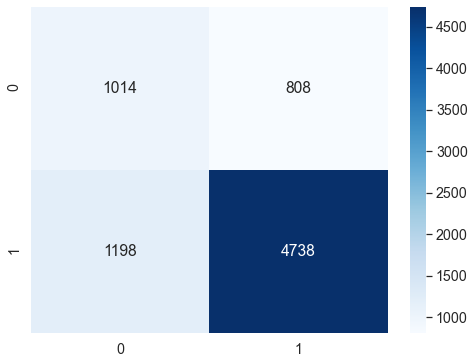

In [70]:
# AdaBoost confusion matrix (test set)
cm = confusion_matrix(y_test.astype("int"), np.round(NN_pred))
df_cm = pd.DataFrame(cm, range(2), range(2))

plt.figure(figsize=(8,6))
sns.set(font_scale=1.3)
sns.heatmap(df_cm, annot=True, cmap='Blues',fmt='g');

In [71]:
#NN for oversampled training set
over_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(20, activation='relu',input_shape=(len(X_train_imputed.columns),)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model 
over_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy']) 
over_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 20)                3120      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [72]:
# fit model 
over_history = over_model.fit(np.array(X_train_over), np.array(y_train_over), validation_split=0.1,epochs=500, 
                    verbose=2)

Epoch 1/500
1336/1336 - 2s - loss: 0.5980 - accuracy: 0.6842 - val_loss: 0.6476 - val_accuracy: 0.6608
Epoch 2/500
1336/1336 - 2s - loss: 0.5598 - accuracy: 0.7230 - val_loss: 0.6134 - val_accuracy: 0.6721
Epoch 3/500
1336/1336 - 2s - loss: 0.5470 - accuracy: 0.7315 - val_loss: 0.6383 - val_accuracy: 0.6505
Epoch 4/500
1336/1336 - 2s - loss: 0.5393 - accuracy: 0.7370 - val_loss: 0.6110 - val_accuracy: 0.6665
Epoch 5/500
1336/1336 - 2s - loss: 0.5321 - accuracy: 0.7435 - val_loss: 0.6168 - val_accuracy: 0.6521
Epoch 6/500
1336/1336 - 2s - loss: 0.5279 - accuracy: 0.7474 - val_loss: 0.6418 - val_accuracy: 0.6088
Epoch 7/500
1336/1336 - 2s - loss: 0.5233 - accuracy: 0.7520 - val_loss: 0.6734 - val_accuracy: 0.5944
Epoch 8/500
1336/1336 - 2s - loss: 0.5185 - accuracy: 0.7545 - val_loss: 0.6456 - val_accuracy: 0.6201
Epoch 9/500
1336/1336 - 2s - loss: 0.5164 - accuracy: 0.7556 - val_loss: 0.5694 - val_accuracy: 0.6778
Epoch 10/500
1336/1336 - 2s - loss: 0.5147 - accuracy: 0.7579 - val_loss:

Epoch 80/500
1336/1336 - 2s - loss: 0.4722 - accuracy: 0.7918 - val_loss: 0.5908 - val_accuracy: 0.6787
Epoch 81/500
1336/1336 - 2s - loss: 0.4721 - accuracy: 0.7889 - val_loss: 0.6150 - val_accuracy: 0.6633
Epoch 82/500
1336/1336 - 2s - loss: 0.4725 - accuracy: 0.7884 - val_loss: 0.6127 - val_accuracy: 0.6726
Epoch 83/500
1336/1336 - 2s - loss: 0.4695 - accuracy: 0.7910 - val_loss: 0.5808 - val_accuracy: 0.6848
Epoch 84/500
1336/1336 - 2s - loss: 0.4714 - accuracy: 0.7883 - val_loss: 0.6085 - val_accuracy: 0.6778
Epoch 85/500
1336/1336 - 2s - loss: 0.4689 - accuracy: 0.7919 - val_loss: 0.5491 - val_accuracy: 0.7039
Epoch 86/500
1336/1336 - 2s - loss: 0.4705 - accuracy: 0.7900 - val_loss: 0.5934 - val_accuracy: 0.6837
Epoch 87/500
1336/1336 - 2s - loss: 0.4688 - accuracy: 0.7915 - val_loss: 0.6134 - val_accuracy: 0.6692
Epoch 88/500
1336/1336 - 2s - loss: 0.4701 - accuracy: 0.7894 - val_loss: 0.6144 - val_accuracy: 0.6728
Epoch 89/500
1336/1336 - 2s - loss: 0.4679 - accuracy: 0.7920 - 

Epoch 159/500
1336/1336 - 2s - loss: 0.4625 - accuracy: 0.7961 - val_loss: 0.6208 - val_accuracy: 0.6711
Epoch 160/500
1336/1336 - 2s - loss: 0.4635 - accuracy: 0.7956 - val_loss: 0.5995 - val_accuracy: 0.6875
Epoch 161/500
1336/1336 - 2s - loss: 0.4624 - accuracy: 0.7948 - val_loss: 0.5894 - val_accuracy: 0.6818
Epoch 162/500
1336/1336 - 2s - loss: 0.4615 - accuracy: 0.7980 - val_loss: 0.5919 - val_accuracy: 0.6862
Epoch 163/500
1336/1336 - 2s - loss: 0.4620 - accuracy: 0.7966 - val_loss: 0.6076 - val_accuracy: 0.6848
Epoch 164/500
1336/1336 - 2s - loss: 0.4610 - accuracy: 0.7976 - val_loss: 0.6014 - val_accuracy: 0.6911
Epoch 165/500
1336/1336 - 2s - loss: 0.4639 - accuracy: 0.7946 - val_loss: 0.6110 - val_accuracy: 0.6650
Epoch 166/500
1336/1336 - 2s - loss: 0.4601 - accuracy: 0.7969 - val_loss: 0.5994 - val_accuracy: 0.6835
Epoch 167/500
1336/1336 - 2s - loss: 0.4593 - accuracy: 0.7972 - val_loss: 0.6195 - val_accuracy: 0.6635
Epoch 168/500
1336/1336 - 2s - loss: 0.4622 - accuracy:

1336/1336 - 2s - loss: 0.4587 - accuracy: 0.7981 - val_loss: 0.6028 - val_accuracy: 0.6869
Epoch 238/500
1336/1336 - 2s - loss: 0.4545 - accuracy: 0.7998 - val_loss: 0.6313 - val_accuracy: 0.6812
Epoch 239/500
1336/1336 - 2s - loss: 0.4573 - accuracy: 0.8000 - val_loss: 0.5834 - val_accuracy: 0.6945
Epoch 240/500
1336/1336 - 2s - loss: 0.4562 - accuracy: 0.7998 - val_loss: 0.5583 - val_accuracy: 0.6970
Epoch 241/500
1336/1336 - 2s - loss: 0.4563 - accuracy: 0.8013 - val_loss: 0.6131 - val_accuracy: 0.6806
Epoch 242/500
1336/1336 - 2s - loss: 0.4567 - accuracy: 0.7990 - val_loss: 0.6040 - val_accuracy: 0.7012
Epoch 243/500
1336/1336 - 2s - loss: 0.4554 - accuracy: 0.8000 - val_loss: 0.6108 - val_accuracy: 0.6799
Epoch 244/500
1336/1336 - 2s - loss: 0.4562 - accuracy: 0.7986 - val_loss: 0.6183 - val_accuracy: 0.6839
Epoch 245/500
1336/1336 - 2s - loss: 0.4569 - accuracy: 0.8005 - val_loss: 0.6127 - val_accuracy: 0.6787
Epoch 246/500
1336/1336 - 2s - loss: 0.4575 - accuracy: 0.8003 - val_

Epoch 316/500
1336/1336 - 2s - loss: 0.4527 - accuracy: 0.8007 - val_loss: 0.6384 - val_accuracy: 0.6812
Epoch 317/500
1336/1336 - 2s - loss: 0.4537 - accuracy: 0.8018 - val_loss: 0.6347 - val_accuracy: 0.6881
Epoch 318/500
1336/1336 - 2s - loss: 0.4537 - accuracy: 0.8022 - val_loss: 0.6237 - val_accuracy: 0.6808
Epoch 319/500
1336/1336 - 2s - loss: 0.4539 - accuracy: 0.8007 - val_loss: 0.5805 - val_accuracy: 0.7060
Epoch 320/500
1336/1336 - 2s - loss: 0.4495 - accuracy: 0.8024 - val_loss: 0.6068 - val_accuracy: 0.6905
Epoch 321/500
1336/1336 - 2s - loss: 0.4539 - accuracy: 0.8014 - val_loss: 0.5968 - val_accuracy: 0.6938
Epoch 322/500
1336/1336 - 2s - loss: 0.4534 - accuracy: 0.8016 - val_loss: 0.5973 - val_accuracy: 0.6888
Epoch 323/500
1336/1336 - 2s - loss: 0.4520 - accuracy: 0.8022 - val_loss: 0.5895 - val_accuracy: 0.6940
Epoch 324/500
1336/1336 - 2s - loss: 0.4535 - accuracy: 0.8004 - val_loss: 0.6116 - val_accuracy: 0.6926
Epoch 325/500
1336/1336 - 2s - loss: 0.4526 - accuracy:

1336/1336 - 2s - loss: 0.4488 - accuracy: 0.8043 - val_loss: 0.5840 - val_accuracy: 0.6932
Epoch 395/500
1336/1336 - 2s - loss: 0.4519 - accuracy: 0.8034 - val_loss: 0.6192 - val_accuracy: 0.6862
Epoch 396/500
1336/1336 - 2s - loss: 0.4498 - accuracy: 0.8051 - val_loss: 0.5865 - val_accuracy: 0.7001
Epoch 397/500
1336/1336 - 2s - loss: 0.4516 - accuracy: 0.8027 - val_loss: 0.6156 - val_accuracy: 0.6829
Epoch 398/500
1336/1336 - 2s - loss: 0.4502 - accuracy: 0.8047 - val_loss: 0.6230 - val_accuracy: 0.6789
Epoch 399/500
1336/1336 - 2s - loss: 0.4493 - accuracy: 0.8042 - val_loss: 0.5636 - val_accuracy: 0.7056
Epoch 400/500
1336/1336 - 2s - loss: 0.4513 - accuracy: 0.8042 - val_loss: 0.6375 - val_accuracy: 0.6772
Epoch 401/500
1336/1336 - 2s - loss: 0.4498 - accuracy: 0.8032 - val_loss: 0.6255 - val_accuracy: 0.6822
Epoch 402/500
1336/1336 - 2s - loss: 0.4513 - accuracy: 0.8020 - val_loss: 0.6147 - val_accuracy: 0.6801
Epoch 403/500
1336/1336 - 2s - loss: 0.4526 - accuracy: 0.8034 - val_

Epoch 473/500
1336/1336 - 2s - loss: 0.4471 - accuracy: 0.8049 - val_loss: 0.6023 - val_accuracy: 0.6915
Epoch 474/500
1336/1336 - 2s - loss: 0.4484 - accuracy: 0.8049 - val_loss: 0.5756 - val_accuracy: 0.6955
Epoch 475/500
1336/1336 - 2s - loss: 0.4480 - accuracy: 0.8038 - val_loss: 0.6440 - val_accuracy: 0.6839
Epoch 476/500
1336/1336 - 2s - loss: 0.4502 - accuracy: 0.8049 - val_loss: 0.6156 - val_accuracy: 0.6860
Epoch 477/500
1336/1336 - 2s - loss: 0.4534 - accuracy: 0.8030 - val_loss: 0.6042 - val_accuracy: 0.6875
Epoch 478/500
1336/1336 - 2s - loss: 0.4479 - accuracy: 0.8044 - val_loss: 0.6133 - val_accuracy: 0.6888
Epoch 479/500
1336/1336 - 2s - loss: 0.4504 - accuracy: 0.8033 - val_loss: 0.5916 - val_accuracy: 0.6911
Epoch 480/500
1336/1336 - 2s - loss: 0.4495 - accuracy: 0.8027 - val_loss: 0.6064 - val_accuracy: 0.6953
Epoch 481/500
1336/1336 - 2s - loss: 0.4483 - accuracy: 0.8055 - val_loss: 0.5831 - val_accuracy: 0.6940
Epoch 482/500
1336/1336 - 2s - loss: 0.4533 - accuracy:

In [73]:
print(roc_auc_score(y_test.astype("int"), over_model.predict(X_test_imputed)))

0.7886132097662295


              precision    recall  f1-score   support

           0       0.43      0.73      0.54      1822
           1       0.90      0.71      0.79      5936

    accuracy                           0.71      7758
   macro avg       0.66      0.72      0.67      7758
weighted avg       0.79      0.71      0.73      7758

0.7893695221939496


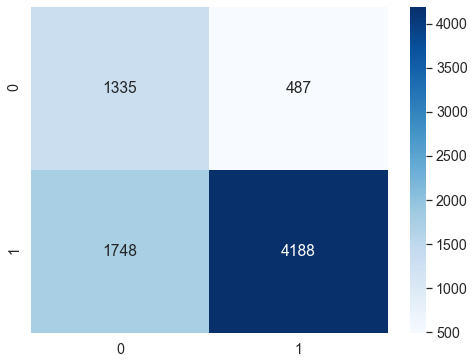

In [74]:
# make predictions
NN_over_pred = over_model.predict(np.array(X_test_imputed))

print(classification_report(y_test.astype("int"), np.round(NN_over_pred)))
print(f1_score(y_test.astype("int"), np.round(NN_over_pred)))

# AdaBoost confusion matrix (test set)
cm = confusion_matrix(y_test.astype("int"), np.round(NN_over_pred))
df_cm = pd.DataFrame(cm, range(2), range(2))

plt.figure(figsize=(8,6))
sns.set(font_scale=1.3)
sns.heatmap(df_cm, annot=True, cmap='Blues',fmt='g');

In [75]:
#SMOTE model
smote_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(20, activation='relu',input_shape=(len(X_train_imputed.columns),)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model 
smote_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy']) 
smote_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 20)                3120      
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_10 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_11 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [76]:
# fit model 
smote_history = smote_model.fit(np.array(X_train_smote), np.array(y_train_smote), validation_split=0.2,epochs=500, 
                    verbose=2)

Epoch 1/500
750/750 - 2s - loss: 0.5865 - accuracy: 0.6927 - val_loss: 0.7451 - val_accuracy: 0.5655
Epoch 2/500
750/750 - 1s - loss: 0.5468 - accuracy: 0.7322 - val_loss: 0.7457 - val_accuracy: 0.5317
Epoch 3/500
750/750 - 1s - loss: 0.5379 - accuracy: 0.7383 - val_loss: 0.7582 - val_accuracy: 0.5560
Epoch 4/500
750/750 - 1s - loss: 0.5329 - accuracy: 0.7422 - val_loss: 0.7087 - val_accuracy: 0.5525
Epoch 5/500
750/750 - 1s - loss: 0.5274 - accuracy: 0.7398 - val_loss: 0.7158 - val_accuracy: 0.5585
Epoch 6/500
750/750 - 1s - loss: 0.5248 - accuracy: 0.7474 - val_loss: 0.7497 - val_accuracy: 0.5668
Epoch 7/500
750/750 - 1s - loss: 0.5216 - accuracy: 0.7495 - val_loss: 0.6719 - val_accuracy: 0.6078
Epoch 8/500
750/750 - 1s - loss: 0.5190 - accuracy: 0.7505 - val_loss: 0.7239 - val_accuracy: 0.5923
Epoch 9/500
750/750 - 1s - loss: 0.5171 - accuracy: 0.7499 - val_loss: 0.6747 - val_accuracy: 0.6103
Epoch 10/500
750/750 - 1s - loss: 0.5134 - accuracy: 0.7539 - val_loss: 0.6634 - val_accura

Epoch 82/500
750/750 - 1s - loss: 0.4627 - accuracy: 0.7901 - val_loss: 0.6099 - val_accuracy: 0.6862
Epoch 83/500
750/750 - 1s - loss: 0.4647 - accuracy: 0.7850 - val_loss: 0.5697 - val_accuracy: 0.7025
Epoch 84/500
750/750 - 1s - loss: 0.4643 - accuracy: 0.7860 - val_loss: 0.6539 - val_accuracy: 0.6597
Epoch 85/500
750/750 - 1s - loss: 0.4636 - accuracy: 0.7896 - val_loss: 0.6016 - val_accuracy: 0.6747
Epoch 86/500
750/750 - 1s - loss: 0.4655 - accuracy: 0.7878 - val_loss: 0.5838 - val_accuracy: 0.6870
Epoch 87/500
750/750 - 1s - loss: 0.4645 - accuracy: 0.7859 - val_loss: 0.6279 - val_accuracy: 0.6457
Epoch 88/500
750/750 - 1s - loss: 0.4606 - accuracy: 0.7903 - val_loss: 0.6083 - val_accuracy: 0.6877
Epoch 89/500
750/750 - 1s - loss: 0.4669 - accuracy: 0.7863 - val_loss: 0.6502 - val_accuracy: 0.6553
Epoch 90/500
750/750 - 1s - loss: 0.4636 - accuracy: 0.7895 - val_loss: 0.6304 - val_accuracy: 0.6722
Epoch 91/500
750/750 - 1s - loss: 0.4648 - accuracy: 0.7885 - val_loss: 0.6414 - v

Epoch 162/500
750/750 - 1s - loss: 0.4508 - accuracy: 0.7980 - val_loss: 0.6346 - val_accuracy: 0.6707
Epoch 163/500
750/750 - 1s - loss: 0.4536 - accuracy: 0.7966 - val_loss: 0.6217 - val_accuracy: 0.6828
Epoch 164/500
750/750 - 1s - loss: 0.4554 - accuracy: 0.7970 - val_loss: 0.6417 - val_accuracy: 0.6693
Epoch 165/500
750/750 - 1s - loss: 0.4545 - accuracy: 0.7938 - val_loss: 0.6085 - val_accuracy: 0.6802
Epoch 166/500
750/750 - 1s - loss: 0.4522 - accuracy: 0.7966 - val_loss: 0.6602 - val_accuracy: 0.6680
Epoch 167/500
750/750 - 1s - loss: 0.4562 - accuracy: 0.7943 - val_loss: 0.6490 - val_accuracy: 0.6690
Epoch 168/500
750/750 - 1s - loss: 0.4538 - accuracy: 0.7949 - val_loss: 0.5951 - val_accuracy: 0.6842
Epoch 169/500
750/750 - 1s - loss: 0.4523 - accuracy: 0.7972 - val_loss: 0.6424 - val_accuracy: 0.6798
Epoch 170/500
750/750 - 1s - loss: 0.4546 - accuracy: 0.7943 - val_loss: 0.6294 - val_accuracy: 0.6698
Epoch 171/500
750/750 - 1s - loss: 0.4545 - accuracy: 0.7950 - val_loss: 

Epoch 242/500
750/750 - 1s - loss: 0.4460 - accuracy: 0.8018 - val_loss: 0.5984 - val_accuracy: 0.6887
Epoch 243/500
750/750 - 1s - loss: 0.4479 - accuracy: 0.7965 - val_loss: 0.5967 - val_accuracy: 0.6862
Epoch 244/500
750/750 - 1s - loss: 0.4470 - accuracy: 0.7995 - val_loss: 0.6069 - val_accuracy: 0.6798
Epoch 245/500
750/750 - 1s - loss: 0.4466 - accuracy: 0.7998 - val_loss: 0.6087 - val_accuracy: 0.6762
Epoch 246/500
750/750 - 1s - loss: 0.4484 - accuracy: 0.7996 - val_loss: 0.6220 - val_accuracy: 0.6673
Epoch 247/500
750/750 - 1s - loss: 0.4490 - accuracy: 0.7967 - val_loss: 0.6367 - val_accuracy: 0.6700
Epoch 248/500
750/750 - 1s - loss: 0.4477 - accuracy: 0.8003 - val_loss: 0.6332 - val_accuracy: 0.6682
Epoch 249/500
750/750 - 1s - loss: 0.4477 - accuracy: 0.7985 - val_loss: 0.5941 - val_accuracy: 0.6857
Epoch 250/500
750/750 - 1s - loss: 0.4478 - accuracy: 0.7999 - val_loss: 0.6249 - val_accuracy: 0.6707
Epoch 251/500
750/750 - 1s - loss: 0.4507 - accuracy: 0.7959 - val_loss: 

Epoch 322/500
750/750 - 1s - loss: 0.4466 - accuracy: 0.7998 - val_loss: 0.6351 - val_accuracy: 0.6742
Epoch 323/500
750/750 - 1s - loss: 0.4435 - accuracy: 0.8029 - val_loss: 0.6449 - val_accuracy: 0.6610
Epoch 324/500
750/750 - 1s - loss: 0.4447 - accuracy: 0.8022 - val_loss: 0.5724 - val_accuracy: 0.7000
Epoch 325/500
750/750 - 1s - loss: 0.4435 - accuracy: 0.8017 - val_loss: 0.5809 - val_accuracy: 0.7087
Epoch 326/500
750/750 - 1s - loss: 0.4460 - accuracy: 0.8003 - val_loss: 0.6166 - val_accuracy: 0.6928
Epoch 327/500
750/750 - 1s - loss: 0.4444 - accuracy: 0.8014 - val_loss: 0.6284 - val_accuracy: 0.6692
Epoch 328/500
750/750 - 1s - loss: 0.4452 - accuracy: 0.8006 - val_loss: 0.6146 - val_accuracy: 0.6845
Epoch 329/500
750/750 - 1s - loss: 0.4437 - accuracy: 0.7999 - val_loss: 0.6175 - val_accuracy: 0.6677
Epoch 330/500
750/750 - 1s - loss: 0.4431 - accuracy: 0.8019 - val_loss: 0.5639 - val_accuracy: 0.7028
Epoch 331/500
750/750 - 1s - loss: 0.4482 - accuracy: 0.7990 - val_loss: 

Epoch 402/500
750/750 - 1s - loss: 0.4404 - accuracy: 0.8044 - val_loss: 0.5831 - val_accuracy: 0.6995
Epoch 403/500
750/750 - 1s - loss: 0.4409 - accuracy: 0.8043 - val_loss: 0.6051 - val_accuracy: 0.6957
Epoch 404/500
750/750 - 1s - loss: 0.4451 - accuracy: 0.8019 - val_loss: 0.5697 - val_accuracy: 0.7330
Epoch 405/500
750/750 - 1s - loss: 0.4426 - accuracy: 0.8020 - val_loss: 0.6019 - val_accuracy: 0.6867
Epoch 406/500
750/750 - 1s - loss: 0.4439 - accuracy: 0.8024 - val_loss: 0.6104 - val_accuracy: 0.6868
Epoch 407/500
750/750 - 1s - loss: 0.4431 - accuracy: 0.8010 - val_loss: 0.6128 - val_accuracy: 0.6807
Epoch 408/500
750/750 - 1s - loss: 0.4416 - accuracy: 0.8034 - val_loss: 0.6083 - val_accuracy: 0.6760
Epoch 409/500
750/750 - 1s - loss: 0.4431 - accuracy: 0.8028 - val_loss: 0.6406 - val_accuracy: 0.6675
Epoch 410/500
750/750 - 1s - loss: 0.4433 - accuracy: 0.8028 - val_loss: 0.6064 - val_accuracy: 0.6890
Epoch 411/500
750/750 - 1s - loss: 0.4429 - accuracy: 0.8060 - val_loss: 

Epoch 482/500
750/750 - 1s - loss: 0.4393 - accuracy: 0.8042 - val_loss: 0.5940 - val_accuracy: 0.6880
Epoch 483/500
750/750 - 1s - loss: 0.4399 - accuracy: 0.8033 - val_loss: 0.6182 - val_accuracy: 0.6842
Epoch 484/500
750/750 - 1s - loss: 0.4419 - accuracy: 0.8044 - val_loss: 0.6492 - val_accuracy: 0.6650
Epoch 485/500
750/750 - 1s - loss: 0.4404 - accuracy: 0.8023 - val_loss: 0.6095 - val_accuracy: 0.6752
Epoch 486/500
750/750 - 1s - loss: 0.4452 - accuracy: 0.8007 - val_loss: 0.6048 - val_accuracy: 0.6937
Epoch 487/500
750/750 - 1s - loss: 0.4397 - accuracy: 0.8034 - val_loss: 0.6147 - val_accuracy: 0.6818
Epoch 488/500
750/750 - 1s - loss: 0.4398 - accuracy: 0.8046 - val_loss: 0.6258 - val_accuracy: 0.6757
Epoch 489/500
750/750 - 1s - loss: 0.4392 - accuracy: 0.8036 - val_loss: 0.5717 - val_accuracy: 0.7118
Epoch 490/500
750/750 - 1s - loss: 0.4396 - accuracy: 0.8040 - val_loss: 0.6364 - val_accuracy: 0.6673
Epoch 491/500
750/750 - 1s - loss: 0.4406 - accuracy: 0.8032 - val_loss: 

In [77]:
print(roc_auc_score(y_test.astype("int"), smote_model.predict(X_test_imputed)))

0.7705214938117824


              precision    recall  f1-score   support

           0       0.51      0.54      0.52      1822
           1       0.86      0.84      0.85      5936

    accuracy                           0.77      7758
   macro avg       0.68      0.69      0.69      7758
weighted avg       0.77      0.77      0.77      7758

0.8484797010361813


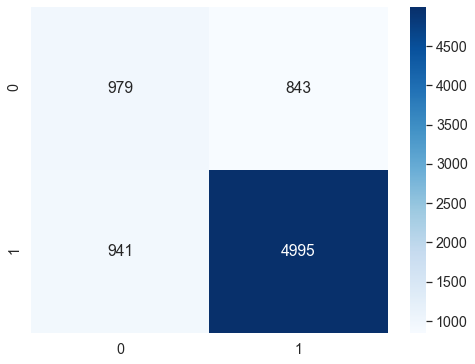

In [78]:
# make predictions
NN_smote_pred = smote_model.predict(np.array(X_test_imputed))

print(classification_report(y_test.astype("int"), np.round(NN_smote_pred)))
print(f1_score(y_test.astype("int"), np.round(NN_smote_pred)))

# AdaBoost confusion matrix (test set)
cm = confusion_matrix(y_test.astype("int"), np.round(NN_smote_pred))
df_cm = pd.DataFrame(cm, range(2), range(2))

plt.figure(figsize=(8,6))
sns.set(font_scale=1.3)
sns.heatmap(df_cm, annot=True, cmap='Blues',fmt='g');